In [ ]:
!pip install nixtlats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.7 MB/s eta 0:00:00


In [ ]:
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nixtlats import TimeGPT
import statsmodels.api as sm
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
exp_SellOut = {
    'LT_1': pd.read_csv("/content/drive/MyDrive/folder/Segmented/LT1_2129725008_200006_sellOut.csv"),
    'LT_2': pd.read_csv("/content/drive/MyDrive/folder/Segmented/LT3_2607565003_200006_sellOut.csv"),
    'LT_3': pd.read_csv("/content/drive/MyDrive/folder/Segmented/LT2_3265728005_100115_sellOut.csv"),
    'ST_1': pd.read_csv("/content/drive/MyDrive/folder/Segmented/ST1_657959003_200003_sellOut.csv"),
    'ST_2': pd.read_csv("/content/drive/MyDrive/folder/Segmented/ST2_3489994004_200001_sellOut.csv")
}

for key, value in exp_SellOut.items():
    exp_SellOut[key] = value.drop(['Unnamed: 0'], axis=1)


In [ ]:
zero_counts = {}

# Loop through each DataFrame in the exp_SellOut dictionary
for key, value in exp_SellOut.items():
    # Count the number of zeros in the 'Actual Input' column
    zero_count = (value['Actual Input'] == 0).sum()

    # Store the count in the zero_counts dictionary with the DataFrame's key
    zero_counts[key] = zero_count
zero_counts


{'LT_1': 64, 'LT_2': 110, 'LT_3': 85, 'ST_1': 6, 'ST_2': 3}

In [ ]:
def Info_plot(data, data_name):
  print(data.info())
  data.rename(columns = {'Day':'date'}, inplace = True)
  data['date'] = pd.to_datetime(data['date'])
  plt.figure(figsize=(20,5))
  plt.plot(data['date'], data['Actual Input'])
  plt.xlabel('Time')
  plt.xticks(rotation=90, fontsize ='small')
  plt.ylabel('Actual Input')
  plt.title(f'{data_name} Actual Input and Time')
  ax =  plt.gca()
  ax.xaxis.set_major_locator(mdates.MonthLocator())
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
  plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Day           226 non-null    object
 1   Actual Input  226 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.7+ KB
None


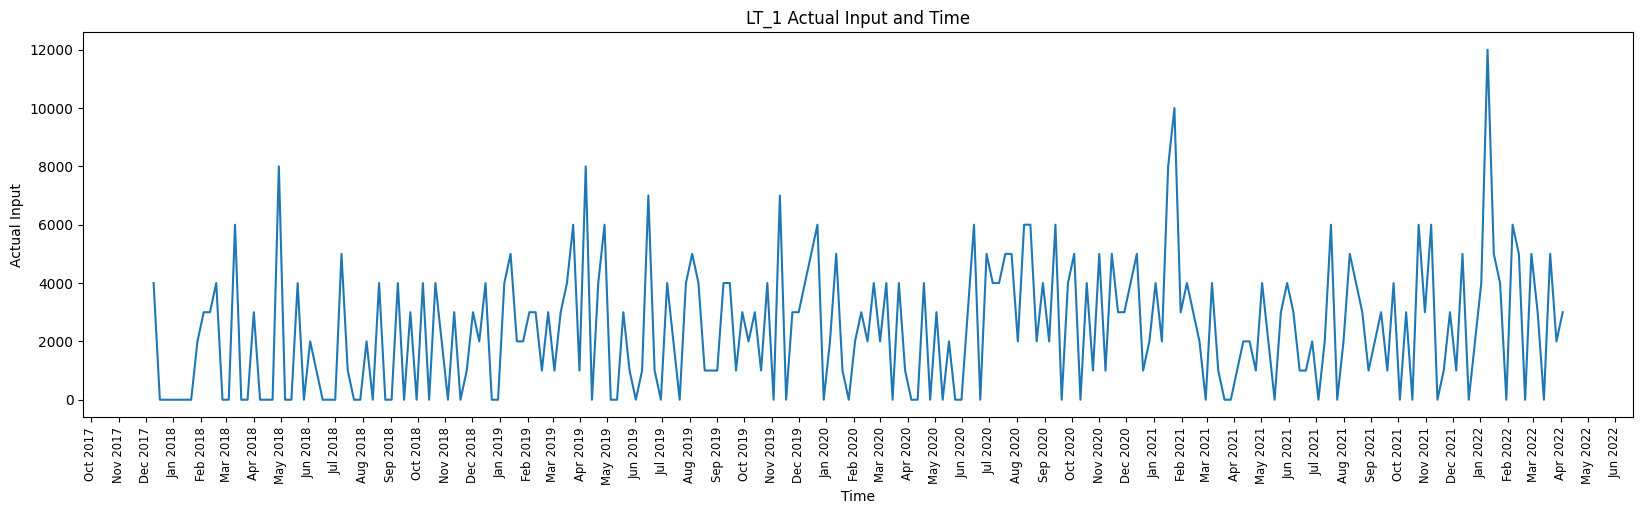

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Day           224 non-null    object
 1   Actual Input  224 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ KB
None


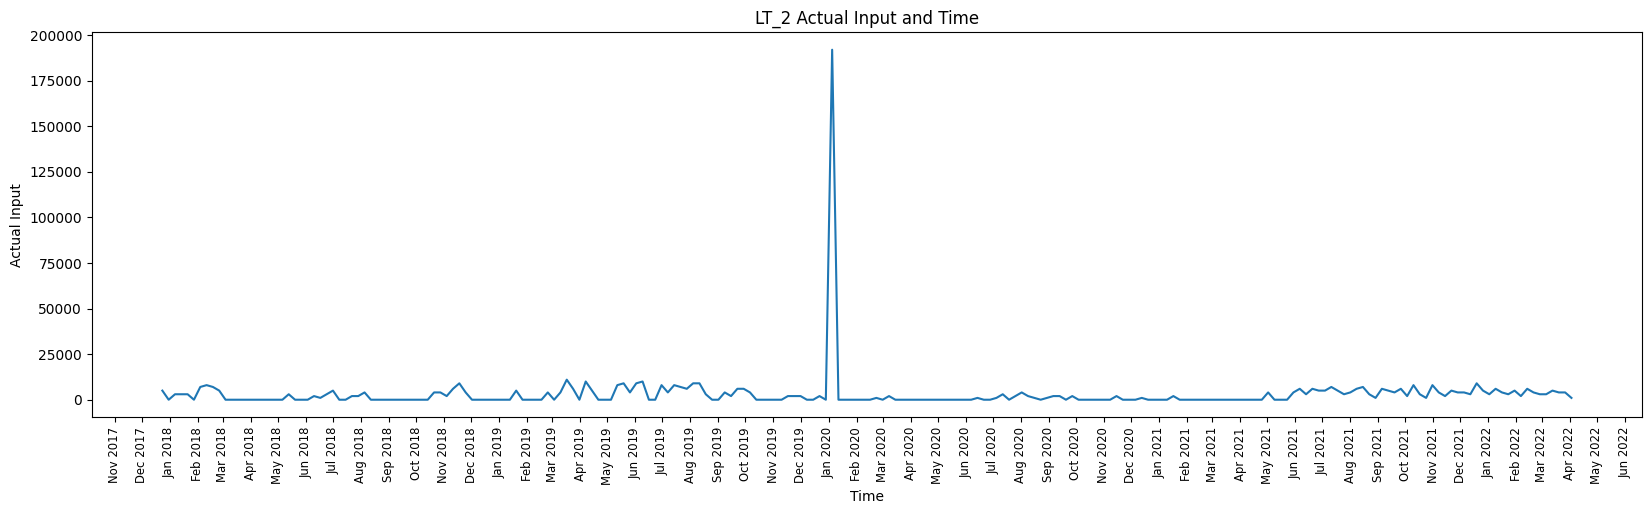

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Day           197 non-null    object
 1   Actual Input  197 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.2+ KB
None


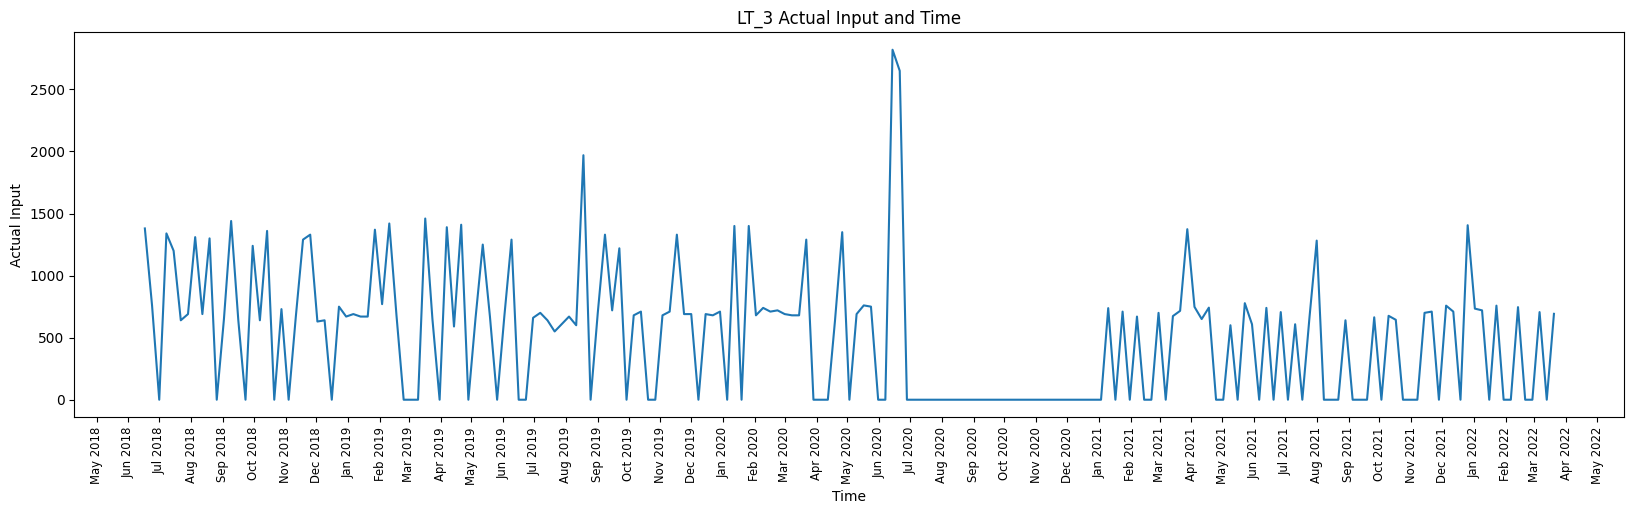

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Day           66 non-null     object
 1   Actual Input  66 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ KB
None


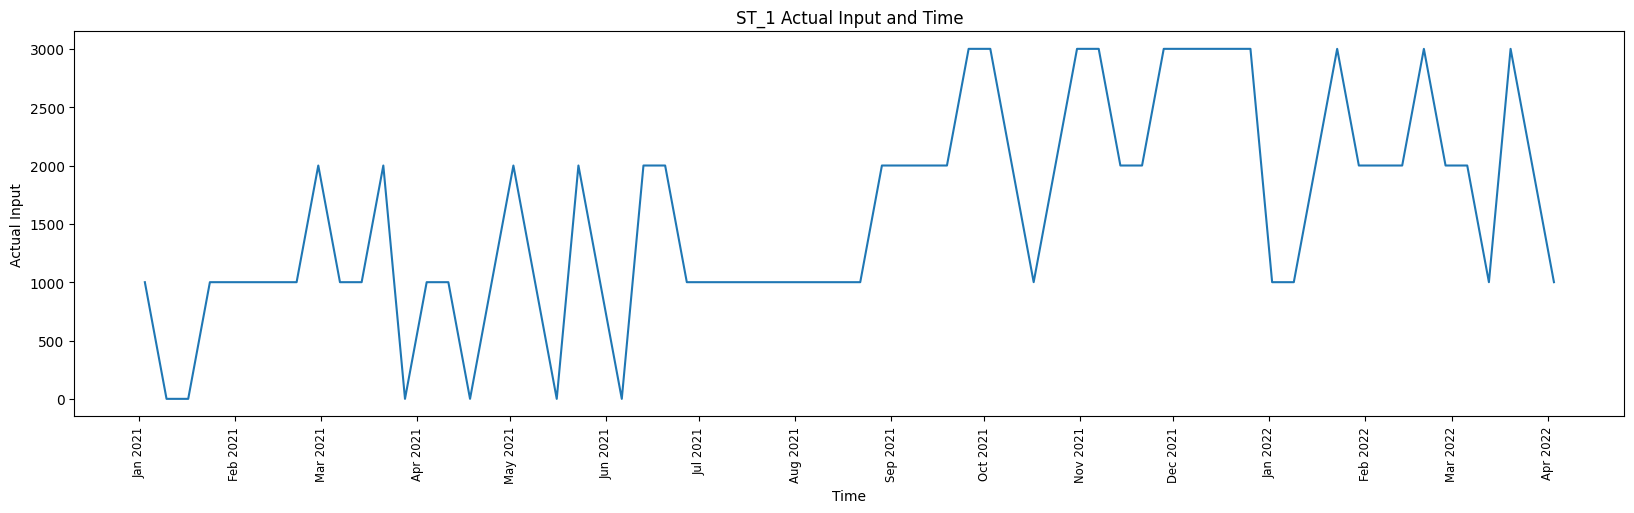

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Day           42 non-null     object
 1   Actual Input  42 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 800.0+ bytes
None


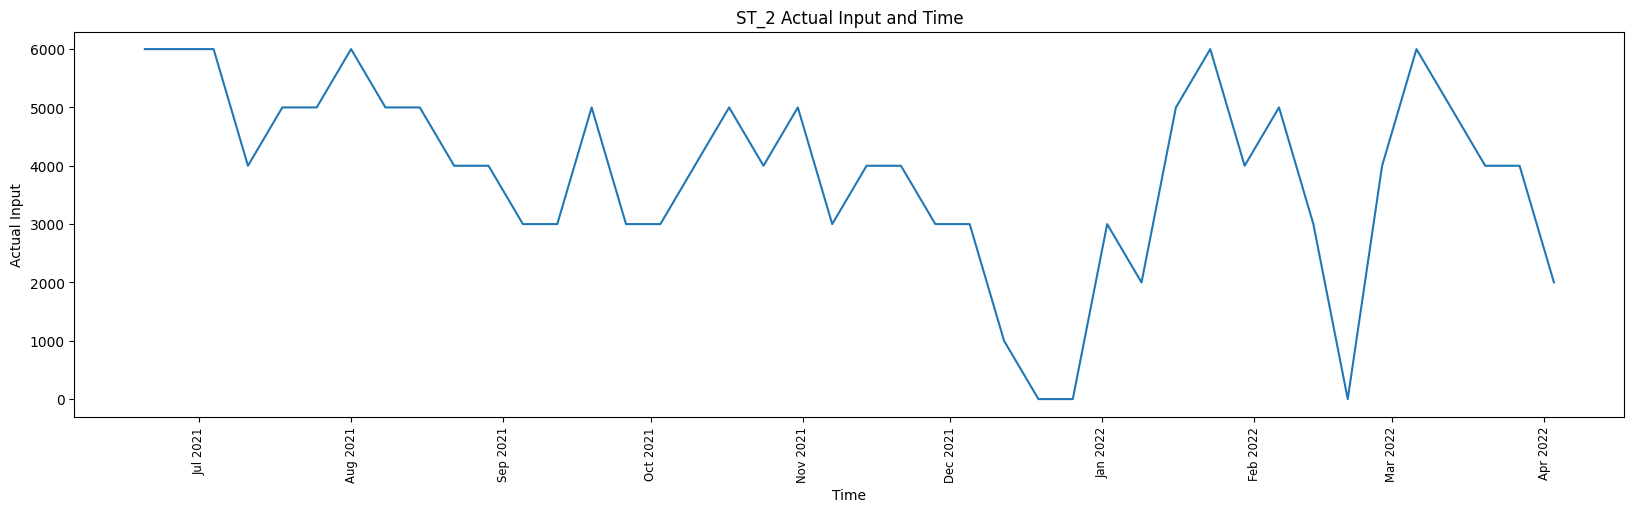

In [ ]:
for name, data in exp_SellOut.items():
  Info_plot(data, name)

In [ ]:
from sklearn.model_selection import train_test_split

# Create dictionaries to store the train and test data for each category
train = {}
test = {}

def data_split(data, data_name, train_dict, test_dict, test_size, random_state=42):
    train_dict[data_name] = data[:-test_size]
    test_dict[data_name] = data[-test_size:]
    train[data_name]= train[data_name].set_index('date')
    test[data_name]= test[data_name].set_index('date')


for name, data in exp_SellOut.items():
    data_split(data, name, train, test, 12, 42)


In [ ]:
y_pred={}

def TES_MODEL(train, test, data_name, alpha, beta, gamma):
  train[data_name]= train[data_name].set_index('date')
  test[data_name]= test[data_name].set_index('date')
  tes_model = ExponentialSmoothing(train[data_name],
                                 trend="add",
                                 seasonal="add",
                                 seasonal_periods=12,
                                 freq='W'
                                 ).fit(smoothing_level=alpha, # alpha
                                        smoothing_trend=beta, # beta
                                        smoothing_seasonal=gamma # gamma
                                        )
  y_pred[data_name] = tes_model.forecast(len(test[data_name]))

In [ ]:
data_and_params = {
    'LT_1': {'alpha': 0.0, 'beta': 0.0, 'gamma': 0.0},
    'LT_2': {'alpha': 0.0, 'beta': 0.0, 'gamma': 0.0},
    'LT_3': {'alpha': 0.0, 'beta': 0.0, 'gamma': 0.0},
    'ST_1': {'alpha': 0.0, 'beta': 0.0, 'gamma': 0.0},
    'ST_2': {'alpha': 0.0, 'beta': 0.0, 'gamma': 0.0}
}


In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error

def find_best_model(train, test, data_name, alphas, betas, gammas, data_and_params):
    best_score = float('inf')
    best_params = (0, 0, 0)
    best_model = None

    for alpha in alphas:
        for beta in betas:
            for gamma in gammas:
                model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12, freq='W').fit(
                    smoothing_level=alpha,
                    smoothing_trend=beta,
                    smoothing_seasonal=gamma
                )
                # Make predictions on the validation/test set
                predictions = model.forecast(len(test))
                # Calculate the performance metric (e.g., Mean Absolute Percentage Error)
                score = mean_absolute_percentage_error(test, predictions)
                if score < best_score:
                    best_score = score
                    best_params = (alpha, beta, gamma)
                    best_model = model

    # Update the data_and_params dictionary with the best parameters and score
    data_and_params[data_name] = {'alpha': best_params[0], 'beta': best_params[1], 'gamma': best_params[2], 'score': best_score}

    return data_and_params


In [ ]:
listexp_SellOut=list(exp_SellOut.keys())
listexp_SellOut

alphas = [0.1, 0.3, 0.5, 0.7, 0.9]
betas = [0.1, 0.3, 0.5, 0.7, 0.9]
gammas = [0.1, 0.3, 0.5, 0.7, 0.9]

for name in listexp_SellOut:
  x = train[name]
  y = test[name]
  find_best_model(x, y, name, alphas, betas, gammas, data_and_params)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_

In [ ]:
data_and_params.items()

dict_items([('LT_1', {'alpha': 0.1, 'beta': 0.1, 'gamma': 0.1, 'score': 4.638453662625299e+18}), ('LT_2', {'alpha': 0.1, 'beta': 0.9, 'gamma': 0.3, 'score': 0.2905340834371875}), ('LT_3', {'alpha': 0.3, 'beta': 0.5, 'gamma': 0.7, 'score': 6.320428805927328e+17}), ('ST_1', {'alpha': 0.3, 'beta': 0.1, 'gamma': 0.1, 'score': 0.2850172130612435}), ('ST_2', {'alpha': 0.3, 'beta': 0.5, 'gamma': 0.7, 'score': 85941741243707.55})])

In [ ]:
y_predTES = {}  # Dictionary to store predictions

def TES_MODEL(train, test, data_name, alpha, beta, gamma):

    tes_model = ExponentialSmoothing(train[data_name], trend="add", seasonal="add", seasonal_periods=12, freq='W').fit(
        smoothing_level=alpha,  # alpha
        smoothing_trend=beta,  # beta
        smoothing_seasonal=gamma  # gamma
    )
    return tes_model.forecast(len(test[data_name]))

for data_name, params in data_and_params.items():
    alpha = params['alpha']
    beta = params['beta']
    gamma = params['gamma']

    predictions = TES_MODEL(train, test, data_name, alpha, beta, gamma)
    y_predTES[data_name] = predictions


In [ ]:
test['LT_1'].reset_index()

,date,Actual Input
0,2022-01-16,5000
1,2022-01-23,4000
2,2022-01-30,0
3,2022-02-06,6000
4,2022-02-13,5000
5,2022-02-20,0
6,2022-02-27,5000
7,2022-03-06,3000
8,2022-03-13,0
9,2022-03-20,5000


In [ ]:
timegpt = TimeGPT(token='s8ghA5oSQ8PnHcRZyEsxN6CCzitO8Vtsx0A98cyrqrtMg5CbwffTnV3qvIzDBXQRlSguspPtY09S3uvr3hnBy67AwkdWak6W4pcCKAeqwOUXeFOcaNz0bfUWM9F7NeU9vbKuCdk867DN5pELECl4oKrvQ5aOGdfTIeALcmk4JY0MWj3BaMVN8dO7Q83c7llcL7SFWtnn2FI97vJY7ZxVCNMOkHutxIzGhT35aL540aRjdOiysnzFh8ThY7LLFKEa') #https://dashboard.nixtla.io

In [ ]:
y_predTimeGPT={}

def TimeGPT(train, test, data_name):
  train[data_name]=train[data_name].reset_index()
  test[data_name]= test[data_name].reset_index()

  return timegpt.forecast(train[data_name], h=len(test[data_name]), freq='W', time_col='date', target_col='Actual Input')


for data_name, params in data_and_params.items():
  y_predTimeGPT[data_name] = TimeGPT(train, test, data_name)
  y_predTimeGPT[data_name].to_csv(f'forecasted_timgpt{data_name}_12.csv')


In [ ]:
Testing = {}

for data_name in data_and_params.keys():
  Testing[data_name]=test[data_name].copy()
  Testing[data_name]['TES'] = y_predTES[data_name].values
  Testing[data_name]['TimeGPT']= y_predTimeGPT[data_name]['TimeGPT'].values


In [ ]:
Testing['LT_1']

,date,Actual Input,TES,TimeGPT
0,2022-01-16,5000,4176.704303,7478.690430
1,2022-01-23,4000,3818.269641,5990.855957
2,2022-01-30,0,4423.236480,5369.398438
3,2022-02-06,6000,3980.361414,4332.060059
4,2022-02-13,5000,3315.012740,3912.728516
5,2022-02-20,0,3927.983434,4041.143311
6,2022-02-27,5000,3653.643846,3821.398193
7,2022-03-06,3000,4282.692007,3996.372070
8,2022-03-13,0,4008.103418,3599.738281
9,2022-03-20,5000,5478.492705,3705.164795


In [ ]:
def calculate_mape(actual, forecast):
  actual_no_zero = np.where(actual == 0, 1, actual)
  return np.mean(np.abs((actual - forecast) / (actual)))

def accuracy_mape(actual, forecast):
    errors = np.abs(actual - forecast)
    return (1 - np.sum(errors) / np.sum(actual))*100

In [ ]:
Testing['LT_2']

,date,Actual Input,TES,TimeGPT
0,2022-01-16,4000,1852.270759,5083.319336
1,2022-01-23,3000,3937.417102,6074.865234
2,2022-01-30,5000,5343.333241,5610.303711
3,2022-02-06,2000,1930.288399,4775.151855
4,2022-02-13,6000,2968.710834,4887.171875
5,2022-02-20,4000,3373.438621,5195.190430
6,2022-02-27,3000,3506.936992,5247.984375
7,2022-03-06,3000,2978.532558,5108.403320
8,2022-03-13,5000,5513.744454,5564.036133
9,2022-03-20,4000,3220.683608,4961.241211


<Figure size 640x480 with 0 Axes>

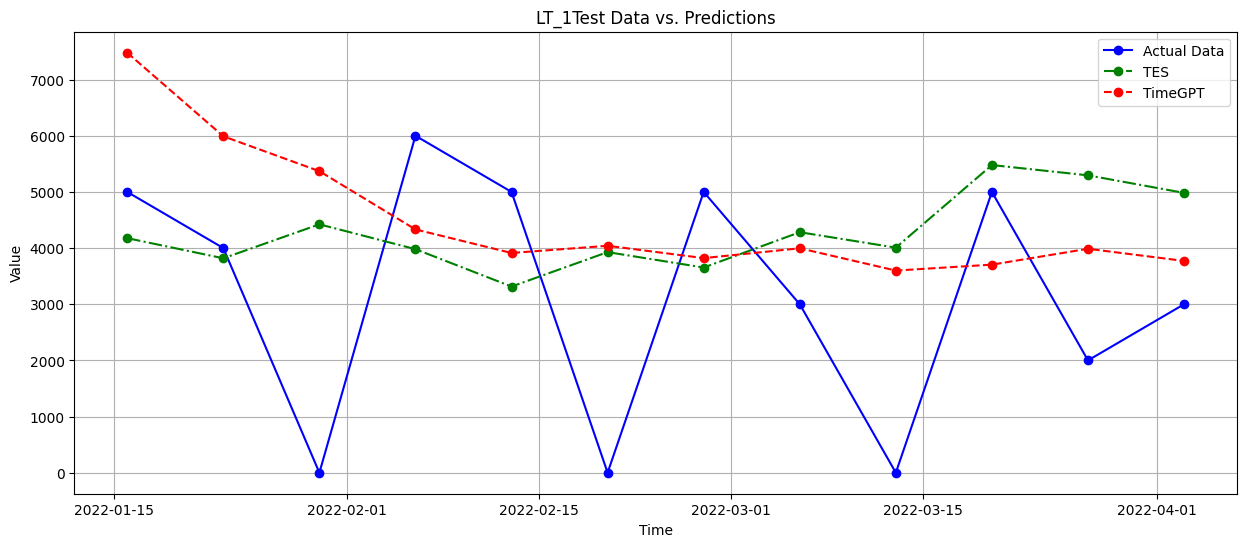

<Figure size 640x480 with 0 Axes>

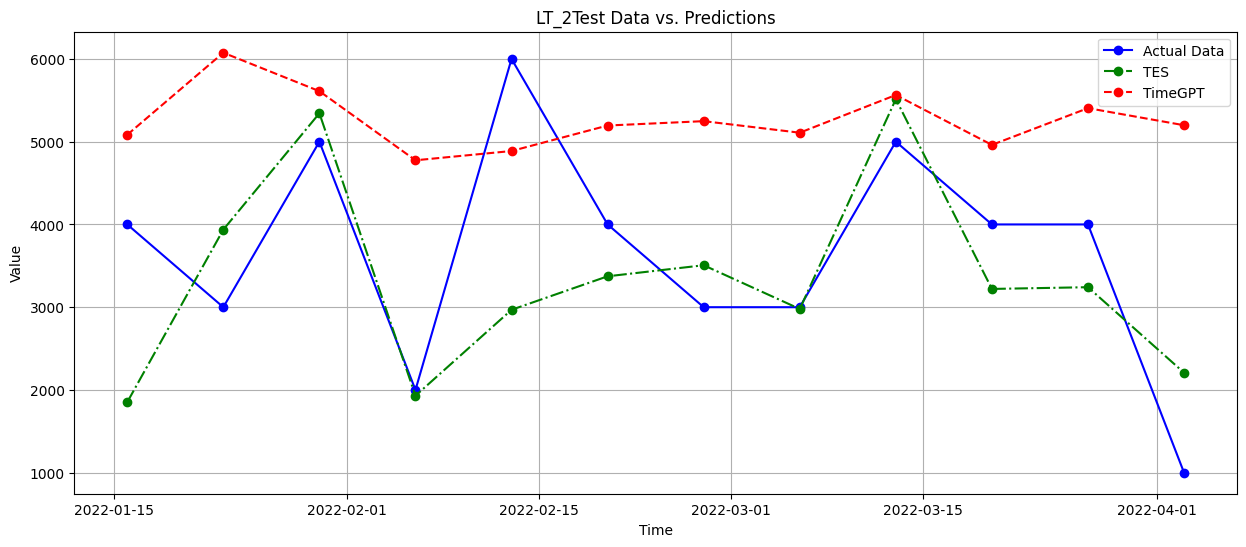

<Figure size 640x480 with 0 Axes>

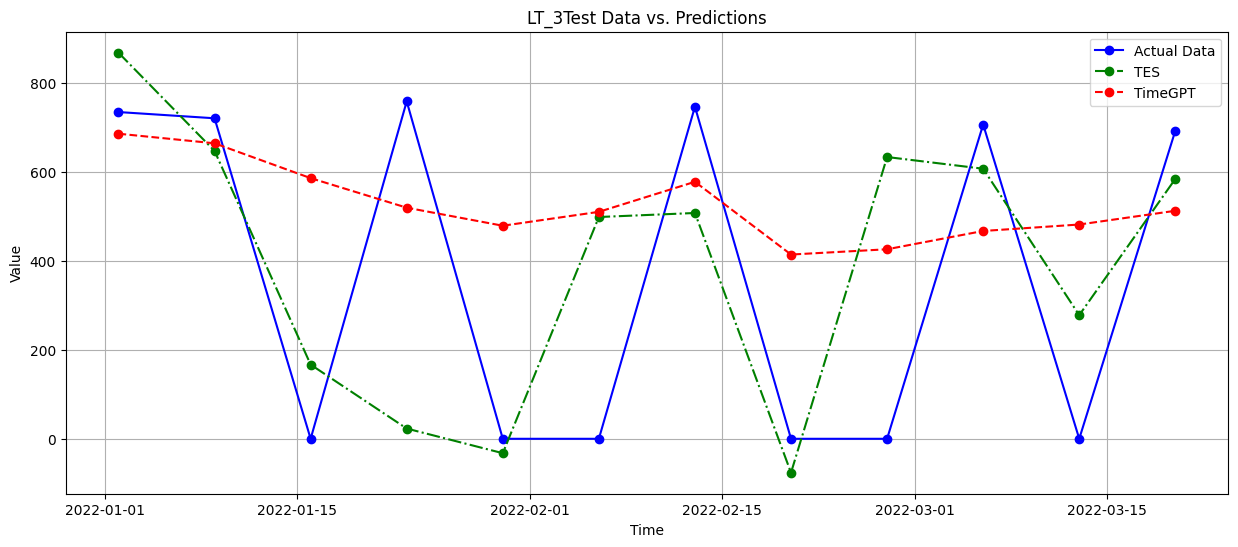

<Figure size 640x480 with 0 Axes>

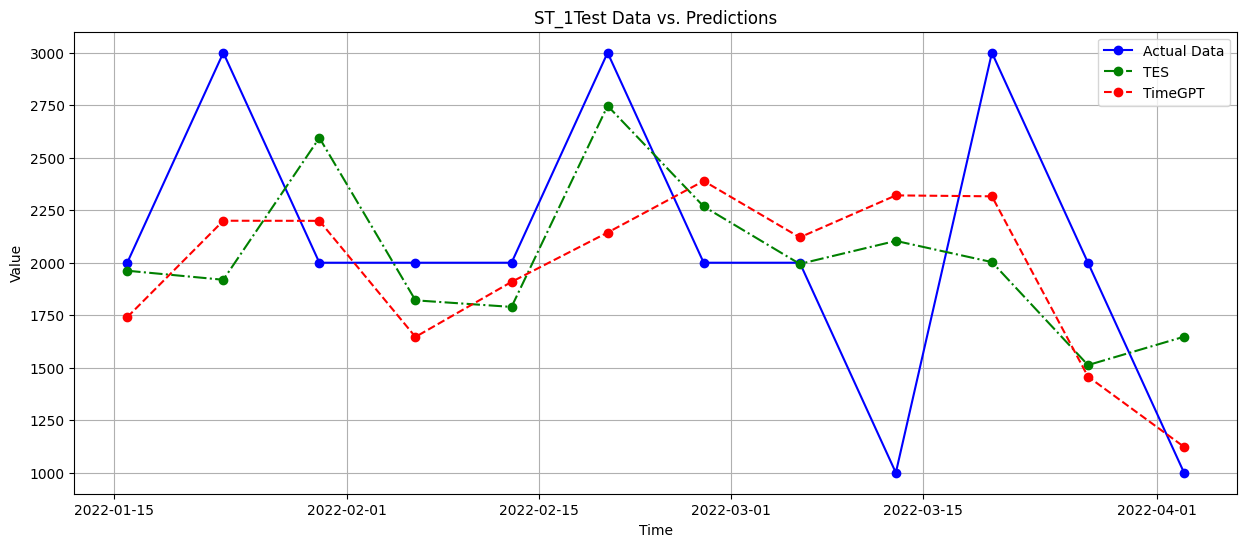

<Figure size 640x480 with 0 Axes>

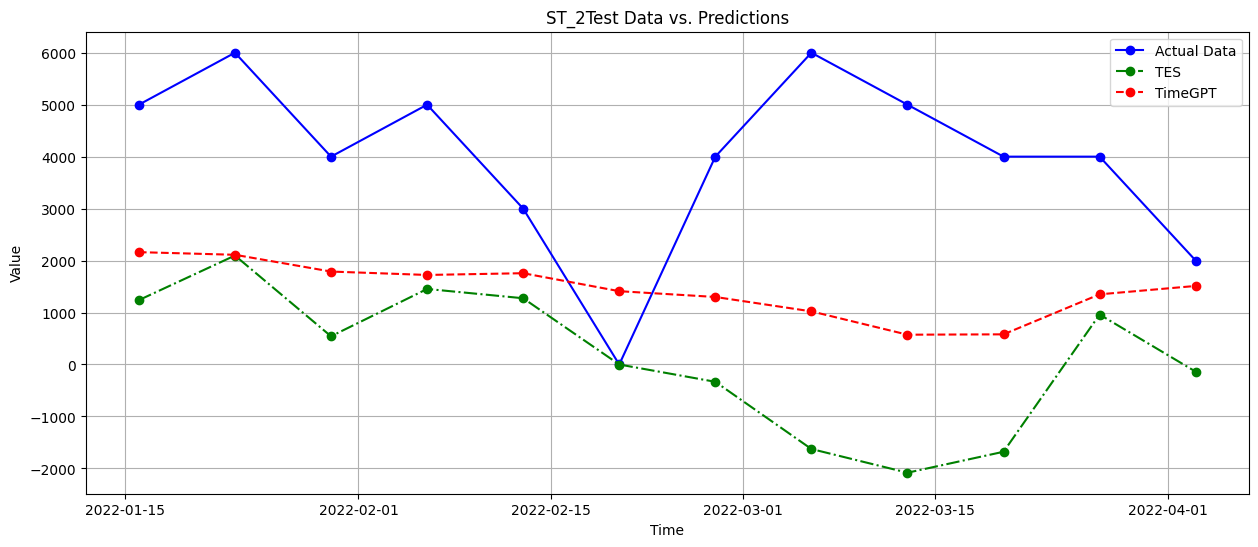

In [ ]:
mapeTES={}
wmapeTES={}

mapeTimeGPT={}
wmapeTimeGPT={}

for data_name in data_and_params.keys():
  # Testing[data_name]['Actual Input']=Testing[data_name]['Actual Input'].replace(0, 1)
  mapeTES[data_name] = calculate_mape(Testing[data_name]['Actual Input'], Testing[data_name]['TES'])
  wmapeTES[data_name] = accuracy_mape(Testing[data_name]['Actual Input'], Testing[data_name]['TES'])

  mapeTimeGPT[data_name] = calculate_mape(Testing[data_name]['Actual Input'], Testing[data_name]['TimeGPT'])
  wmapeTimeGPT[data_name] = accuracy_mape(Testing[data_name]['Actual Input'], Testing[data_name]['TimeGPT'])

  Testing[data_name] = Testing[data_name].sort_index()
  # x = range(len(Testing[data_name]))
  x = Testing[data_name]['date']
  fig1 = plt.gcf()
  plt.figure(figsize=(15, 6))
  plt.plot(x, Testing[data_name]['Actual Input'], label="Actual Data", marker='o', linestyle='-', color='b')
  plt.plot(x, Testing[data_name]['TES'], label="TES", marker='o', linestyle='-.', color='g')
  plt.plot(x, Testing[data_name]['TimeGPT'], label="TimeGPT", marker='o', linestyle='--', color='r')
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.title(f"{data_name}Test Data vs. Predictions")
  plt.legend()
  plt.grid(True)
  plt.show()
  fig1.savefig(f"{data_name}_12.png")

In [ ]:
# for data_name in data_and_params.keys():
#   Testing[data_name] = Testing[data_name].reset_index()

In [ ]:
Testing= pd.read_csv('/content/drive/MyDrive/folder/Segmented/Testing_results_12_LTST.csv')
Testing= Testing.drop(['Unnamed: 0'], axis = 1)
Testing['Actual Input'] = Testing['Actual Input'].replace(0, 1)
Testing

,date,Actual Input,TES,TimeGPT,ID
0,2022-01-16,5000,4176.704303,7478.690430,LT_1
1,2022-01-23,4000,3818.269641,5990.855957,LT_1
2,2022-01-30,1,4423.236480,5369.398438,LT_1
3,2022-02-06,6000,3980.361414,4332.060059,LT_1
4,2022-02-13,5000,3315.012740,3912.728516,LT_1
5,2022-02-20,1,3927.983434,4041.143311,LT_1
6,2022-02-27,5000,3653.643846,3821.398193,LT_1
7,2022-03-06,3000,4282.692007,3996.372070,LT_1
8,2022-03-13,1,4008.103418,3599.738281,LT_1
9,2022-03-20,5000,5478.492705,3705.164795,LT_1


In [ ]:
data_dict = {k: v for k, v in Testing.groupby('ID')}
data_dict['LT_1']['Actual Input']

0     5000
1     4000
2        1
3     6000
4     5000
5        1
6     5000
7     3000
8        1
9     5000
10    2000
11    3000
Name: Actual Input, dtype: int64

In [ ]:
Testing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          60 non-null     object 
 1   Actual Input  60 non-null     int64  
 2   TES           60 non-null     float64
 3   TimeGPT       60 non-null     float64
 4   ID            60 non-null     object 
dtypes: float64(2), int64(1), object(2)
memory usage: 2.5+ KB


<Figure size 640x480 with 0 Axes>

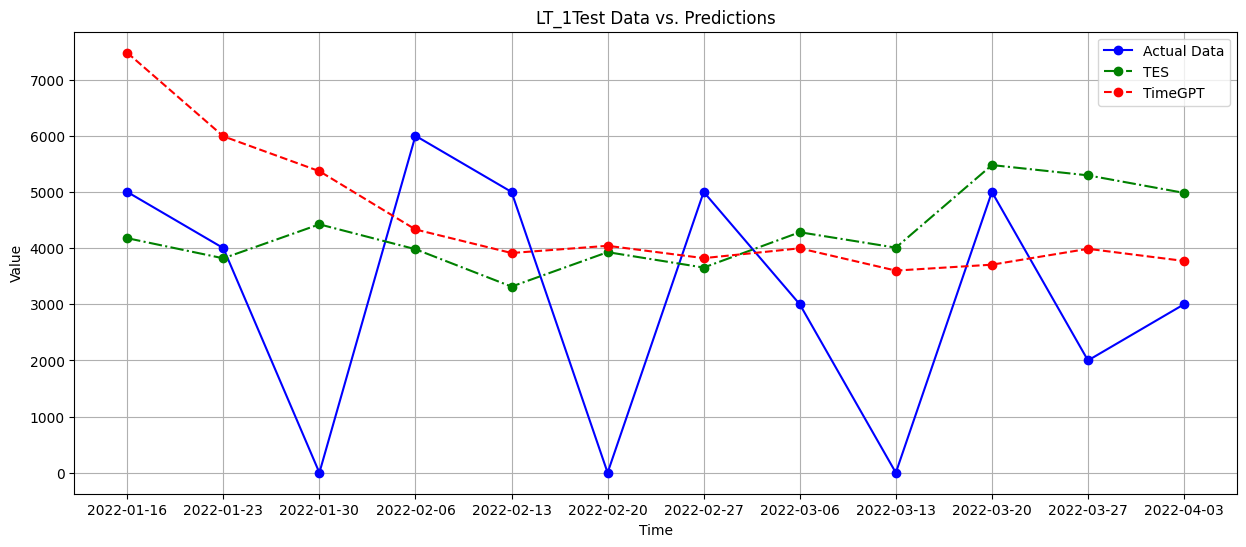

<Figure size 640x480 with 0 Axes>

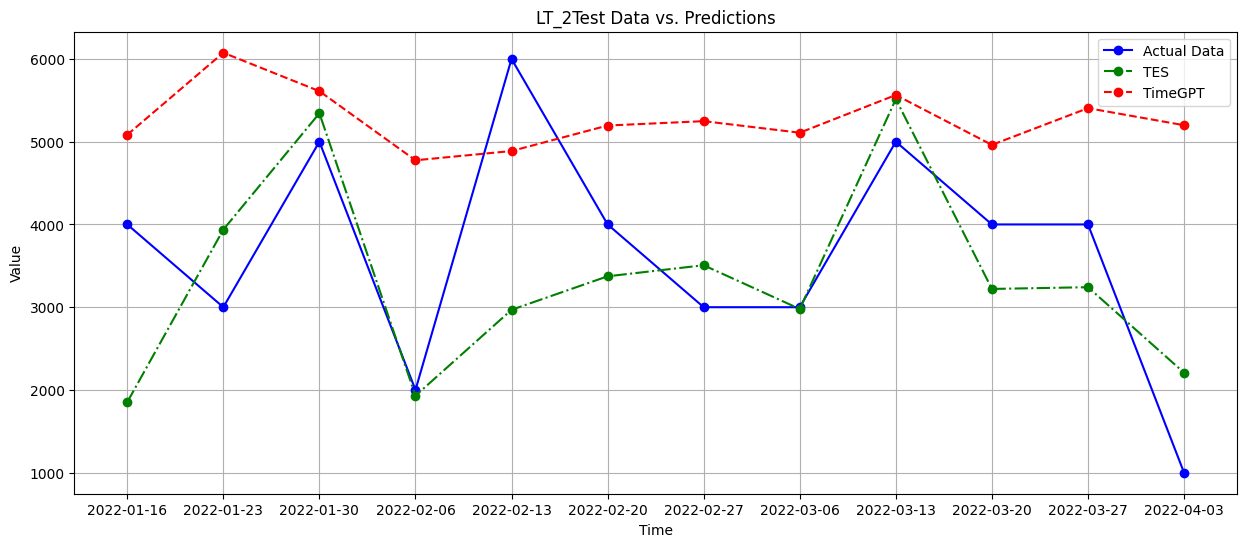

<Figure size 640x480 with 0 Axes>

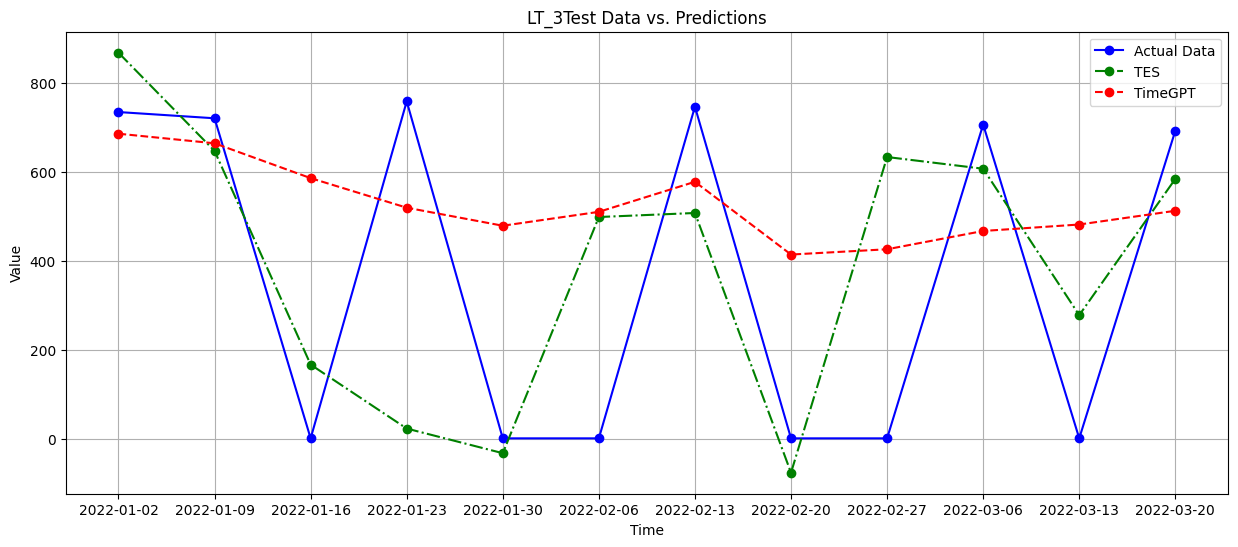

<Figure size 640x480 with 0 Axes>

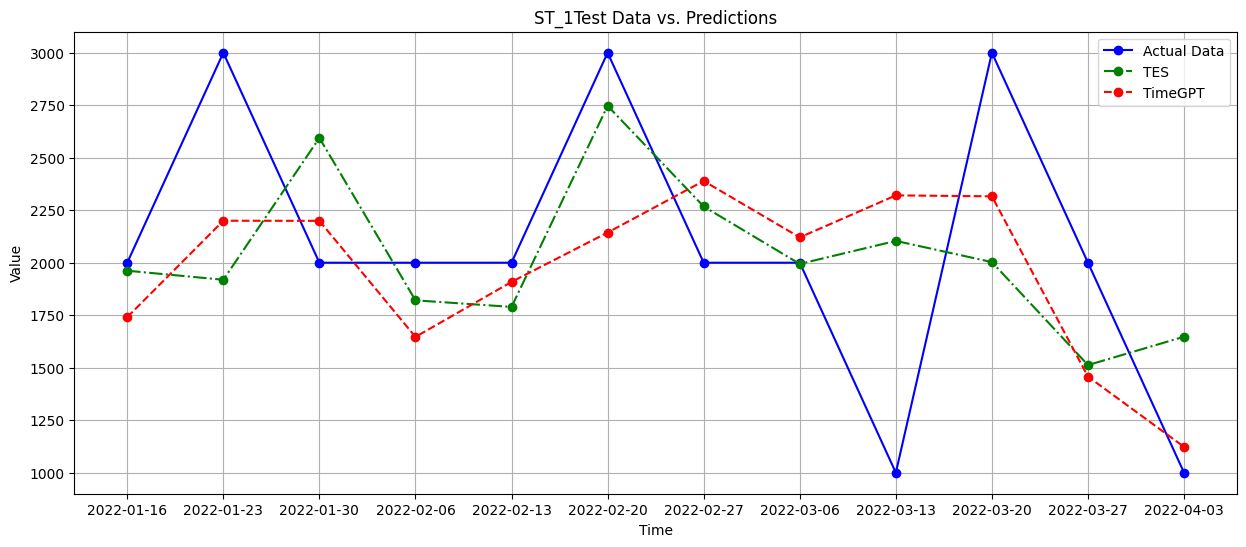

<Figure size 640x480 with 0 Axes>

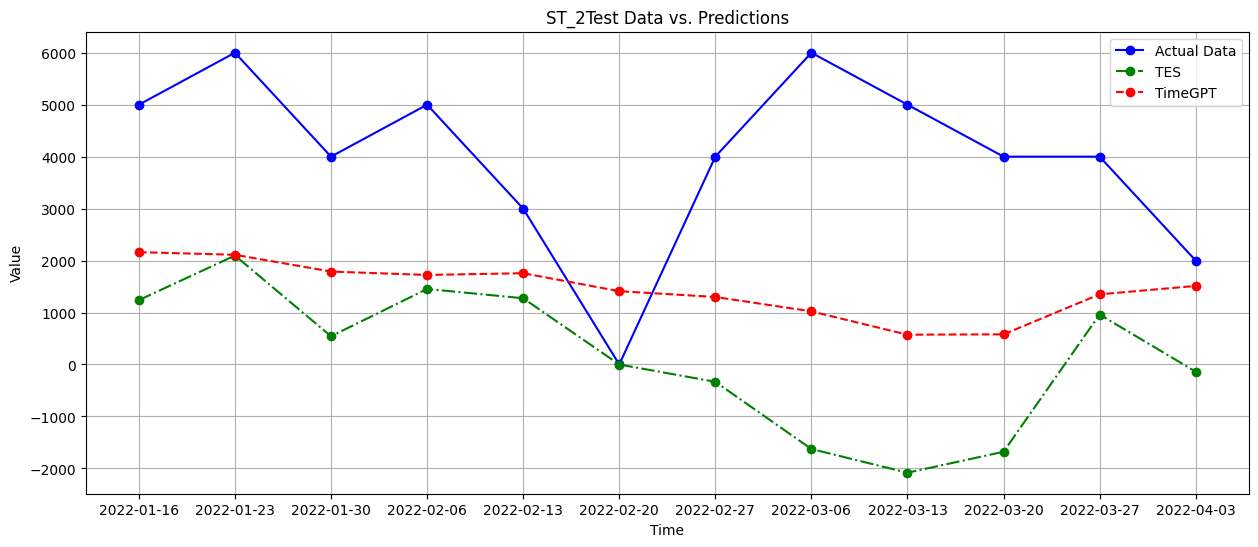

In [ ]:
mapeTES={}
wmapeTES={}

mapeTimeGPT={}
wmapeTimeGPT={}

for data_name in data_dict.keys():
  # data_dict[data_name]['Actual Input']=data_dict[data_name]['Actual Input'].replace(0, 1)
  mapeTES[data_name] = calculate_mape(data_dict[data_name]['Actual Input'], data_dict[data_name]['TES'])
  wmapeTES[data_name] = accuracy_mape(data_dict[data_name]['Actual Input'], data_dict[data_name]['TES'])

  mapeTimeGPT[data_name] = calculate_mape(data_dict[data_name]['Actual Input'], data_dict[data_name]['TimeGPT'])
  wmapeTimeGPT[data_name] = accuracy_mape(data_dict[data_name]['Actual Input'], data_dict[data_name]['TimeGPT'])

  data_dict[data_name] = data_dict[data_name].sort_index()
  # x = range(len(data_dict[data_name]))
  x = data_dict[data_name]['date']
  fig1 = plt.gcf()
  plt.figure(figsize=(15, 6))
  plt.plot(x, data_dict[data_name]['Actual Input'], label="Actual Data", marker='o', linestyle='-', color='b')
  plt.plot(x, data_dict[data_name]['TES'], label="TES", marker='o', linestyle='-.', color='g')
  plt.plot(x, data_dict[data_name]['TimeGPT'], label="TimeGPT", marker='o', linestyle='--', color='r')
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.title(f"{data_name}Test Data vs. Predictions")
  plt.legend()
  plt.grid(True)
  plt.show()
  fig1.savefig(f"{data_name}_12.png")

In [ ]:
for data_name in data_dict.keys():
  # print(data_name)
  # print(mapeTES[data_name])
  # print(wmapeTES[data_name])
  # print(mapeTimeGPT[data_name])
  print(wmapeTimeGPT[data_name])

30.37244155683433
51.50645419034091
12.417277913747283
77.0431708984375
30.14871081482189


In [ ]:
dfs = [df.copy() for key, df in Testing.items()]
for i, key in enumerate(Testing.keys()):
    dfs[i]['ID'] = key

# Combine all Testingframes into one
combined_Testing = pd.concat(dfs, ignore_index=True)
combined_Testing.to_csv("Testing_results_12_LTST.csv")